# Moment Tensor Wavefield Inversion - Single Component
## The inverse crime edition

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

from pylops.basicoperators import HStack, VStack
from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.optimization.sparsity import *


In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.modelling.trueamp_kirchhoff import Kirchhoff as TAKirchhoff

from pyfrac.mtsolvers.mtwi import *
from pyfrac.mtsolvers.homo_mti import collect_source_angles, singlecomp_Greens_Pwave
from pyfrac.mtsolvers.mtutils import *

from pyfrac.visualisation.eventimages import locimage3d
from pyfrac.visualisation.traceviz import traceimage, wiggleplot, multiwiggleplot

# Load eFD Data

In [3]:
data_dir = '../../data/pyfrac_SOFIModelling'

In [4]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

In [5]:
# RECEIVERS
recs_xzy = np.loadtxt(os.path.join(data_dir,'inputs/surfacearray_xzy_20m.dat')).T
nr = recs_xzy.shape[1]
print(nr)


143


In [6]:
expname = 'homo_MT_90_90_180'

# Vz is Vy cause SOFI is not cool (or consistent!)
vz = read_seis(os.path.join(data_dir,'outputs/su/%s_vy.txt'%expname), 
               nr=143)

sdt = 1e-3 #ms
t_shift = 167
tdur = 500
vz = vz[:,t_shift:t_shift+tdur]
vz /= np.max(abs(vz))

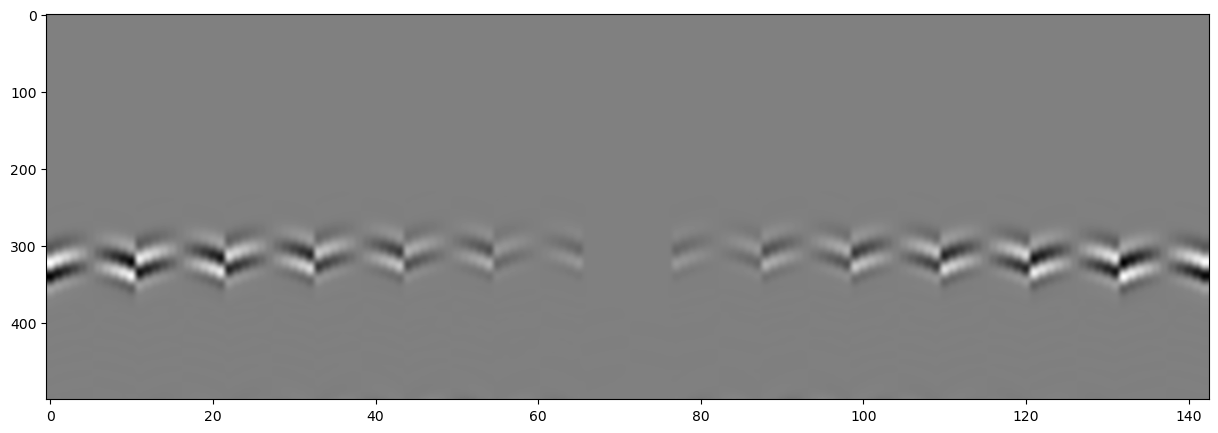

In [7]:
fig,ax = plt.subplots(1,1,figsize=[15,5])
ax.imshow(vz.T, aspect='auto',cmap='binary_r')

# 3D Model - Homo

In [8]:
abs_bounds = 30
dx = dy = dz = 5
nx = 112
ny = 128
nz = 120
print(nx,ny,nz)

mod_w_bounds = np.fromfile(os.path.join(data_dir,'inputs/models/Homogeneous_xyz.vp'),dtype='float32').reshape([nx,ny,nz])

# Remove absorbing boundaries
mod = mod_w_bounds[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,:-abs_bounds] # z has free surface
nx, ny, nz = mod.shape
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz
print(nx,ny,nz)
recs = np.array([recs_xzy[0]-(abs_bounds*dx),recs_xzy[2]-(abs_bounds*dx),recs_xzy[1]])

112 128 120
52 68 90


## Get all necessary components

In [9]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs,  
                                   vel=mod, 
                                   mode='eikonal')

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

In [10]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

### SELECT AREA OF INTEREST

In [11]:
# Source Parameters
omega_p = 20  # Assume central frequency of 25Hz
sx = nx//2
sy = ny//2
sz = 2*nz//3

sloc_ind = [sx, sy, sz]

In [12]:
# Make cube area of interest as can't consider the full subsurface body
hwin_nx_aoi, hwin_ny_aoi, hwin_nz_aoi = 15, 13, 11  # half windows to place source in center of region of interest
xsi, xfi = sloc_ind[0]-hwin_nx_aoi, sloc_ind[0]+hwin_nx_aoi+1   # start/end index of x-region of interest
ysi, yfi = sloc_ind[1]-hwin_ny_aoi, sloc_ind[1]+hwin_ny_aoi+1   # start/end index of y-region of interest
zsi, zfi = sloc_ind[2]-hwin_nz_aoi, sloc_ind[2]+hwin_nz_aoi+1   # start/end index of z-region of interest

In [13]:
# Parameters only for the area of interest
gamma_sourceangles_aoi = gamma_sourceangles[:, :, xsi:xfi, ysi:yfi, zsi:zfi]
dist_table_aoi = dist_table[:, xsi:xfi, ysi:yfi, zsi:zfi]
tt_table_aoi = TTT_full[:, xsi:xfi, ysi:yfi, zsi:zfi]

nr, nx_aoi, ny_aoi, nz_aoi = tt_table_aoi.shape
print(nr, nx_aoi, ny_aoi, nz_aoi)

143 31 27 23


In [14]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for area of interest

In [15]:
Gz = singlecomp_Greens_Pwave(nxyz=[nx_aoi, ny_aoi, nz_aoi],
                                    nr=nr,
                                    gamma_sourceangles=gamma_sourceangles_aoi,
                                    dist_table=dist_table_aoi,
                                    vel=np.mean(mod),
                                    MT_comp_dict=MT_comp_dict,
                                    omega_p=1,
                                    )

In [16]:
Gz.shape

(6, 143, 31, 27, 23)

# Moment Tensor Kirchhoff Imaging

### MAKE OPERATOR

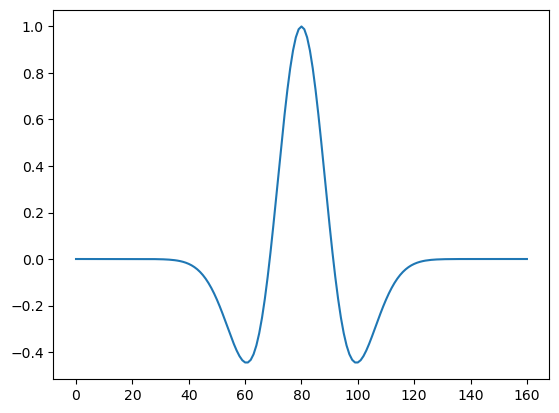

In [17]:
dt = sdt
nt = vz.shape[1]
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:81], f0=omega_p)
plt.plot(wav)

In [49]:
Mstack_Op = singlecomp_pwave_mtioperator(x=x[xsi:xfi],
                                        y=y[ysi:yfi],
                                        z=z[zsi:zfi],
                                        recs=recs,
                                        t=t,
                                        wav=wav,
                                        wavc=wavc,
                                        tt_table=tt_table_aoi,
                                        Gz=Gz,
                                        Ms_scaling = 1e6,
                                        engine='numba'
                                        )

Dot test passed, v^H(Opu)=-0.03795382960420478 - u^H(Op^Hv)=-0.03795382960420505


## Forward operation - to check out the time shift is correct and that all looks reasonable

In [50]:
# Modelled MT
MT_aoi = np.zeros([6, nx_aoi, ny_aoi, nz_aoi])  # MT components as images
MT_selected = -1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 
MT_aoi[:, nx_aoi//2, ny_aoi//2, nz_aoi//2] = MT_selected

# Generated Data
data = Mstack_Op @ MT_aoi.ravel()
data = data.reshape(nr, nt)

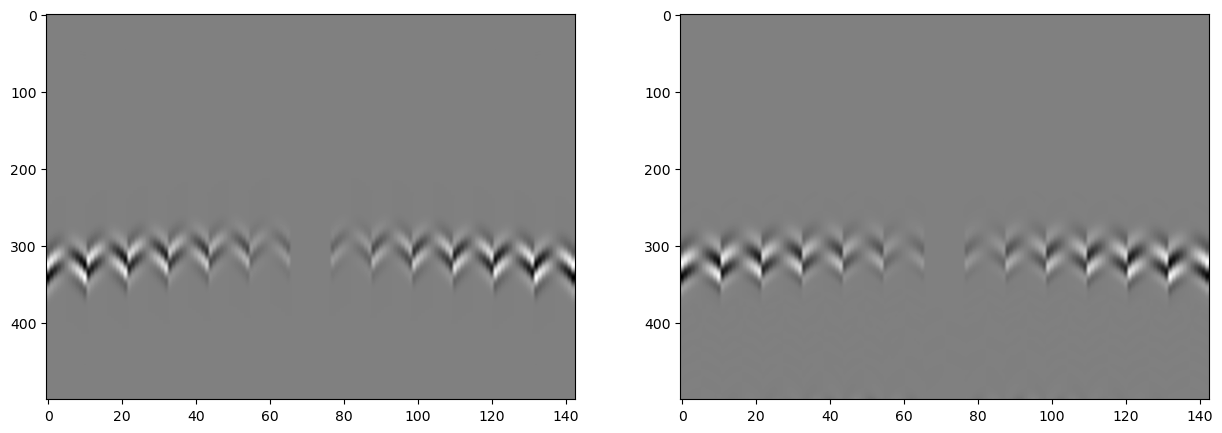

In [51]:
fig,axs = plt.subplots(1,2,figsize=[15,5])
axs[0].imshow(data.T, aspect='auto',cmap='binary_r')
axs[1].imshow(vz.T, aspect='auto',cmap='binary_r')

# Run on Vz data

In [52]:
nxyz=[nx_aoi, ny_aoi, nz_aoi]

# ADJOINT
mt_adj = adjoint_mtmodelling(vz, Mstack_Op, nxyz)

# LSQR
mt_inv = lsqr_mtsolver(vz, Mstack_Op, nxyz)

# FISTA
mt_fista = fista_mtsolver(vz, Mstack_Op, nxyz, fista_niter=100, fista_damping=1e-13, verbose=True)


 
LSQR            Least-squares solution of  Ax = b
The matrix A has 71500 rows and 115506 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.334e+01  2.334e+01    1.0e+00  1.1e-03
     1 -4.44524e-01   1.355e+01  1.355e+01    5.8e-01  4.5e-01   3.1e-02  1.0e+00
     2 -6.57956e-01   8.313e+00  8.313e+00    3.6e-01  3.0e-01   3.7e-02  2.5e+00
     3 -3.00284e-01   6.895e+00  6.895e+00    3.0e-01  2.1e-01   4.3e-02  3.8e+00
     4  1.58906e-01   6.036e+00  6.036e+00    2.6e-01  2.5e-01   4.9e-02  5.4e+00
     5  6.31993e-01   4.969e+00  4.969e+00    2.1e-01  1.1e-01   5.8e-02  8.0e+00
     6  5.46680e-01   4.358e+00  4.358e+00    1.9e-01  1.2e-01   6.1e-02  1.0e+01
     7  3.94736e-01   4.057e+00  4.057e+00    1.7e-01  1.2e-01   6.5e-02  1.2e+01
     8 -6.03916e-03   3.647e+00

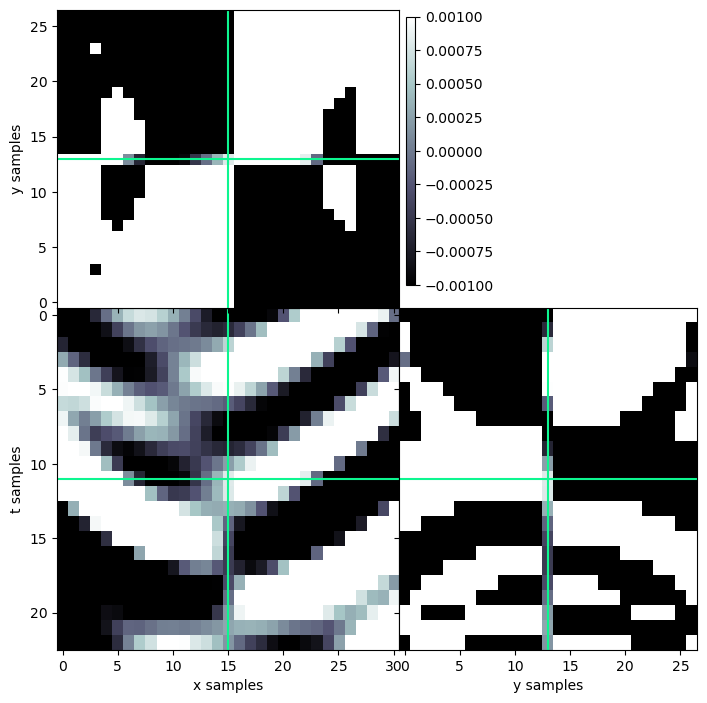

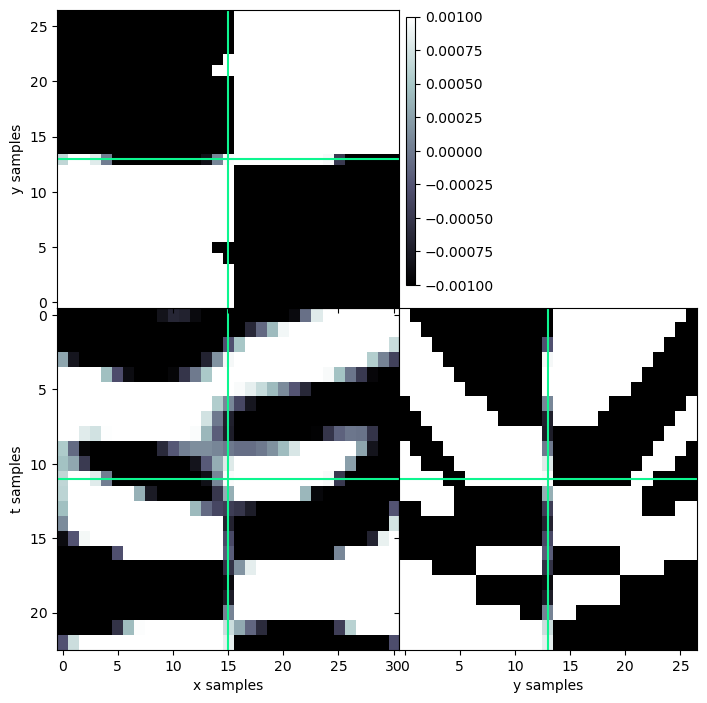

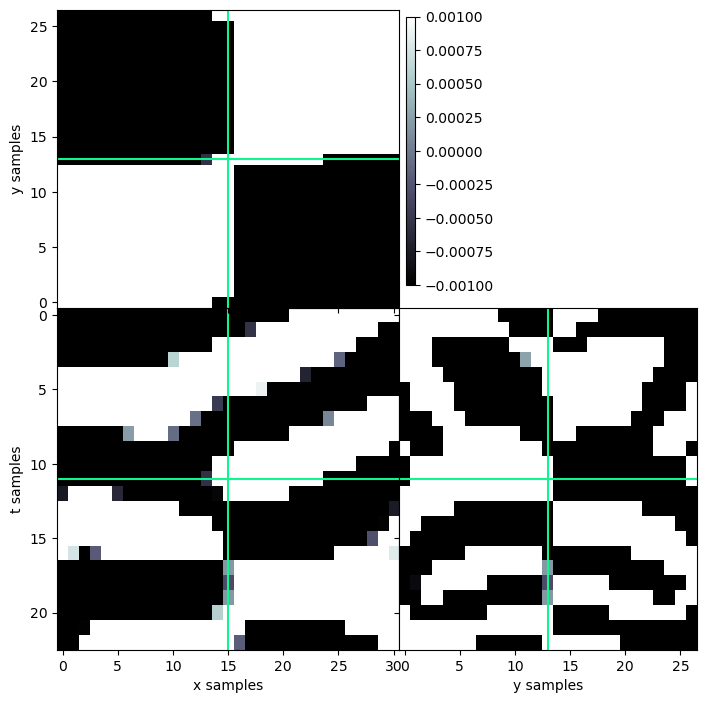

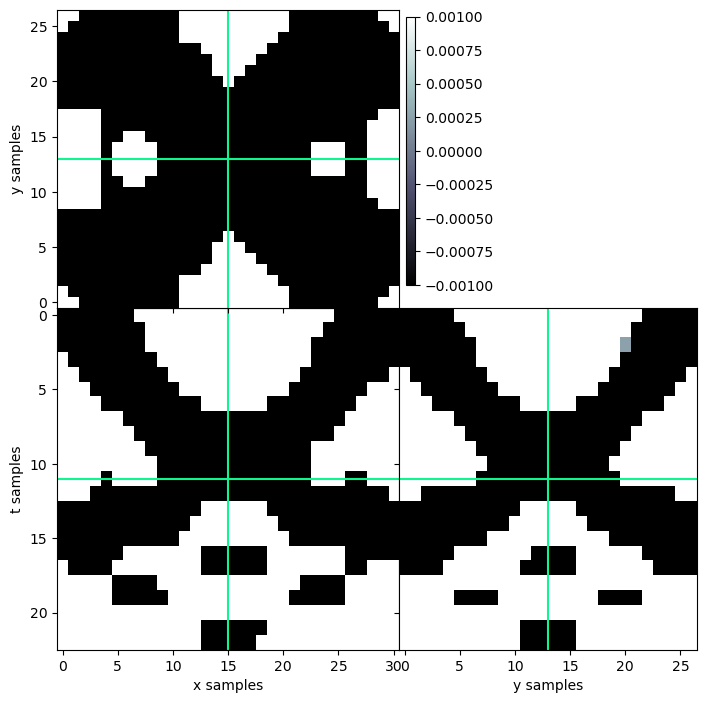

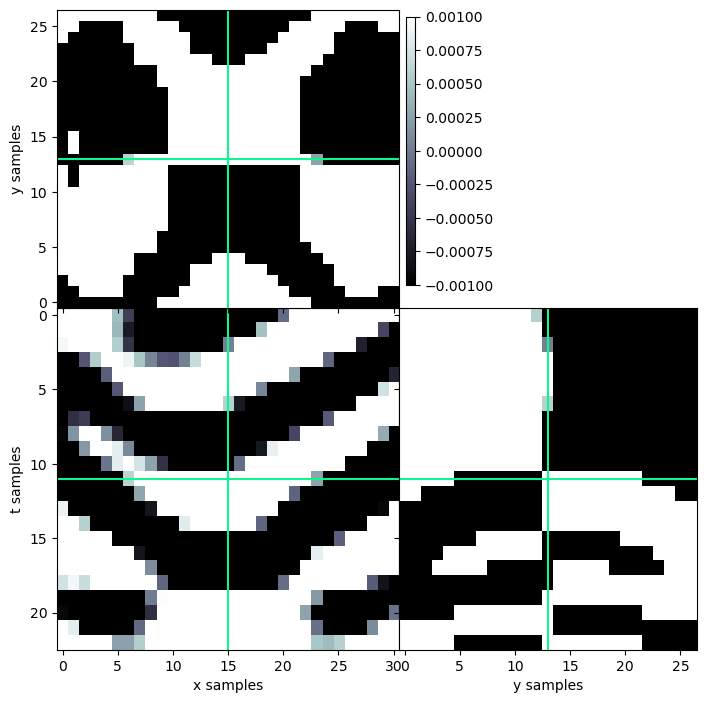

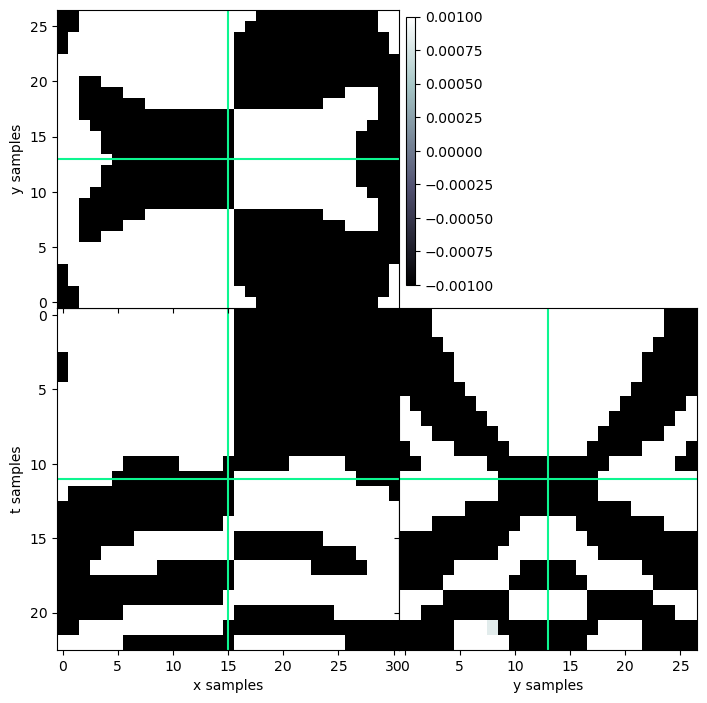

In [53]:
clim = 1e-3
locimage3d(mt_inv[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[2], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[4], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[5], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim]);

In [54]:
exp_sloc, _ = expected_sloc_from_mtwi(mt_inv)
print('Expected Source Location: \n', exp_sloc)
mt_at_loc = get_mt_at_loc(mt_inv, [int(exp_sloc[0]), int(exp_sloc[1]), int(exp_sloc[2])])
print('MT at expected Source Location (full): \n', mt_at_loc)
print('MT at expected Source Location (rounded): \n', np.round(mt_at_loc, decimals=5))

Expected Source Location: 
 [10.4 12.2 14. ]
MT at expected Source Location (full): 
 (-2.1264797995769698, -3.993237344266672, -24.120472624156985, -2.6020601909775456, -2.010331840145813, -5.012389423997289)
MT at expected Source Location (rounded): 
 [ -2.12648  -3.99324 -24.12047  -2.60206  -2.01033  -5.01239]
